# Car Fuel Consumption

### 課題
データから車の燃料消費量を算出、
E10とSP98の2つの燃料のうちどちらが安いか？


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
# distance, consume, temp_insideの小数点識別記号が異なるため変更
df_mm = pd.read_csv('measurements.csv', decimal=',')

display(df_mm.head())
df_mm.info()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null float64
consume          388 non-null float64
speed            388 non-null int64
temp_inside      376 non-null float64
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null float64
refill gas       13 non-null object
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB


In [3]:
# 欠損値が含まれている範囲と量を確認
print('----------- 欠損値の有無を確認 -----------')
print(df_mm.isnull().any())
print('-' * 42)
print('--------- 欠損値の個数をカウント ---------')
print(df_mm.isnull().sum())
print('-' * 42)

----------- 欠損値の有無を確認 -----------
distance         False
consume          False
speed            False
temp_inside       True
temp_outside     False
specials          True
gas_type         False
AC               False
rain             False
sun              False
refill liters     True
refill gas        True
dtype: bool
------------------------------------------
--------- 欠損値の個数をカウント ---------
distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64
------------------------------------------


In [4]:
print('-------- unique値の出現頻度を確認 --------')
print(df_mm['gas_type'].value_counts())
print('-' * 44)

-------- unique値の出現頻度を確認 --------
SP98    228
E10     160
Name: gas_type, dtype: int64
--------------------------------------------


## 前処理

In [5]:
# データ内容上、不要と推定した以下列を削除
df_mm = df_mm.drop(columns='specials')
df_mm = df_mm.drop(columns='refill liters')
df_mm = df_mm.drop(columns='refill gas')

In [6]:
# gas_typeでの違いを数値的に考慮するため、ダミー値に置換
df_mm['gas_type'] = df_mm['gas_type'].replace({'E10': 1, 'SP98': 0})
print(df_mm.head())

   distance  consume  speed  temp_inside  temp_outside  gas_type  AC  rain  \
0      28.0      5.0     26         21.5            12         1   0     0   
1      12.0      4.2     30         21.5            13         1   0     0   
2      11.2      5.5     38         21.5            15         1   0     0   
3      12.9      3.9     36         21.5            14         1   0     0   
4      18.5      4.5     46         21.5            15         1   0     0   

   sun  
0    0  
1    0  
2    0  
3    0  
4    0  


In [7]:
# temp_insideに欠損値が存在するので、平均値で補てん
print('-------- unique値の出現頻度を確認 --------')
print(df_mm['temp_inside'].value_counts())
print('-' * 44)

temp_inside_mean = df_mm['temp_inside'].mean()
print('平均値 = {:.3f}'.format(temp_inside_mean))

df_mm['temp_inside'] = df_mm['temp_inside'].fillna(temp_inside_mean)

-------- unique値の出現頻度を確認 --------
21.5    133
22.0    102
22.5     59
20.0     25
23.0     13
21.0     13
25.0     12
24.5      7
20.5      4
24.0      3
25.5      2
23.5      2
19.0      1
Name: temp_inside, dtype: int64
--------------------------------------------
平均値 = 21.930


In [8]:
# 車内気温と社外気温の差を新しい変数として追加
df_mm['temp_diff'] = abs(df_mm['temp_outside']- df_mm['temp_inside'])

In [9]:
df_mm.describe()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,temp_diff
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.412371,0.077320,0.123711,0.082474,11.109934
std,22.667837,1.033172,13.598524,0.994666,6.991542,0.492897,0.267443,0.329677,0.275441,5.758641
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000,6.500000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,0.000000,11.500000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,1.000000,0.000000,0.000000,0.000000,14.625000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,1.000000,26.000000


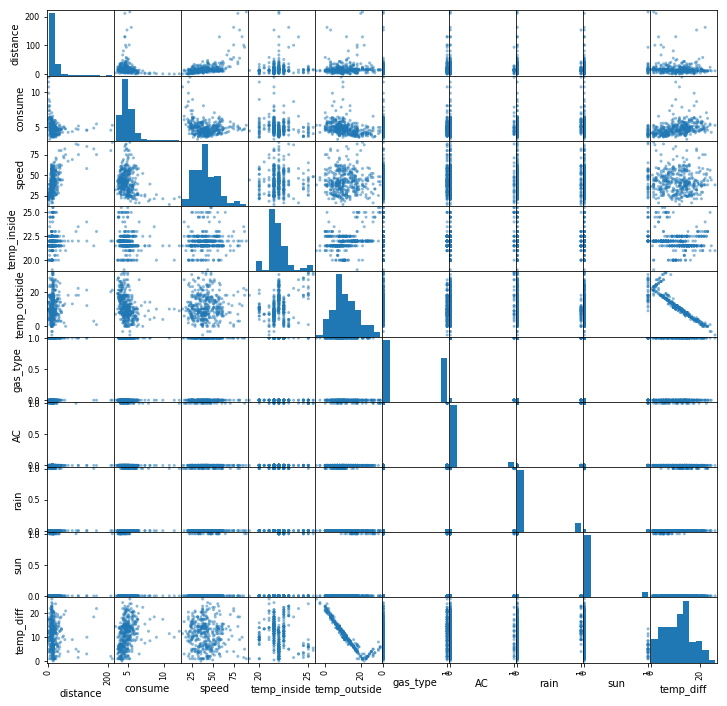

In [10]:
pd.plotting.scatter_matrix(df_mm, figsize=(12,12))
plt.show()

In [11]:
# 相関係数を確認
df_mm.corr()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,temp_diff
distance,1.000000,-0.128967,0.562299,0.075178,0.088175,0.053411,-0.025738,-0.019791,0.081120,-0.104497
consume,-0.128967,1.000000,-0.227866,-0.160623,-0.320811,0.015327,0.096591,0.248118,-0.170667,0.316242
speed,0.562299,-0.227866,1.000000,0.059293,0.015411,0.097360,-0.035408,0.009489,0.081618,-0.024272
temp_inside,0.075178,-0.160623,0.059293,1.000000,0.359500,-0.010198,0.297376,-0.036937,0.242248,-0.149054
temp_outside,0.088175,-0.320811,0.015411,0.359500,1.000000,-0.148705,0.167562,-0.186315,0.346903,-0.938660
gas_type,0.053411,0.015327,0.097360,-0.010198,-0.148705,1.000000,-0.105285,-0.060328,-0.022761,0.133094
AC,-0.025738,0.096591,-0.035408,0.297376,0.167562,-0.105285,1.000000,0.242915,0.088598,-0.071806
rain,-0.019791,0.248118,0.009489,-0.036937,-0.186315,-0.060328,0.242915,1.000000,-0.112650,0.184633
sun,0.081120,-0.170667,0.081618,0.242248,0.346903,-0.022761,0.088598,-0.112650,1.000000,-0.298264
temp_diff,-0.104497,0.316242,-0.024272,-0.149054,-0.938660,0.133094,-0.071806,0.184633,-0.298264,1.000000


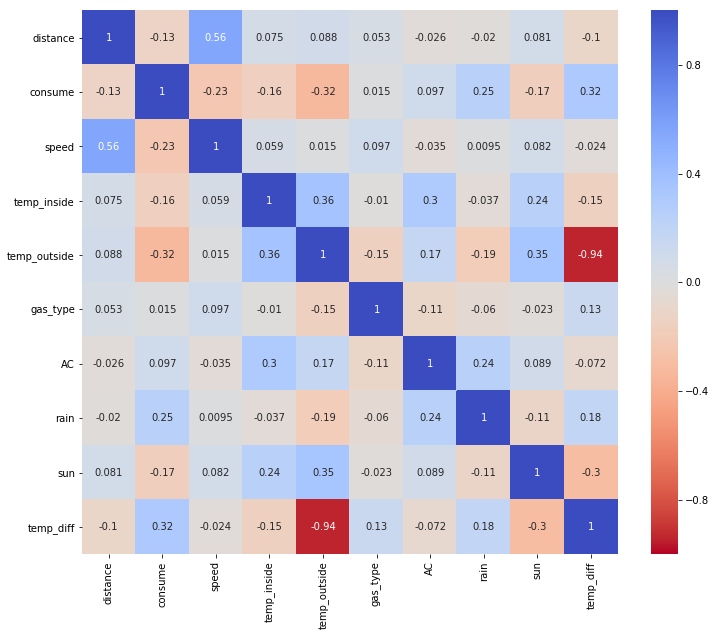

In [12]:
# 相関係数を可視化
plt.figure(figsize=(12,10))
sns.heatmap(df_mm.corr(), annot=True, cmap='coolwarm_r', vmin=-1, vmax=1)
plt.show()

In [13]:
# 係数を求める
y = df_mm['consume'].values
X = df_mm[['distance', 'speed', 'gas_type', 'AC', 'rain', 'sun', 'temp_diff']].values
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]
w4 = regr.coef_[3]
w5 = regr.coef_[4]
w6 = regr.coef_[5]
w7 = regr.coef_[6]

In [14]:
x1 = df_mm['distance'].values
x2 = df_mm['speed'].values
x3 = df_mm['gas_type'].values
x4 = df_mm['AC'].values
x5 = df_mm['rain'].values
x6 = df_mm['sun'].values
x7 = df_mm['temp_diff'].values

y_est = w0 + w1*x1 + w2*x2 + w3*x3 + w4*x4 + w5*x5 + w6*x6 + w7*x7
sq_err = 0.5 * np.sum( (y - y_est)**2 ) / len(df_mm)
rsq_err = np.sqrt(sq_err) / len(df_mm)
abs_err = 0.5 * np.sum(abs(y - y_est)) / len(df_mm)

print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7))
print('MSE（二乗誤差） = {:.3f}'.format(sq_err))
print('RMSE（平方根二乗誤差） = {:.3f}'.format(rsq_err))
print('MAE（絶対誤差） = {:.3f}'.format(abs_err))

w0 = 5.025, w1 = 0.002, w2 = -0.018, w3 = 0.038, w4 = 0.279, w5 = 0.560, w6 = -0.228
MSE（二乗誤差） = 0.428
RMSE（平方根二乗誤差） = 0.002
MAE（絶対誤差） = 0.306


## DAY2

### Ridge

In [15]:
degree = 2
alphas = [0.0, 1e-1, 1e-3, 1e-5]

for alpha in alphas:
    ridge_est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    ridge_est.fit(X, y)

    y_est = ridge_est.predict(X)
    sq_err = 0.5 * np.sum( (y - y_est)**2 ) / len(df_mm)
    rsq_err = np.sqrt(sq_err) / len(df_mm)
    abs_err = 0.5 * np.sum(abs(y - y_est)) / len(df_mm)

    print('MSE（二乗誤差） = {:.3f}'.format(sq_err))
    print('RMSE（平方根二乗誤差） = {:.3f}'.format(rsq_err))
    print('MAE（絶対誤差） = {:.3f}\n'.format(abs_err))

MSE（二乗誤差） = 0.312
RMSE（平方根二乗誤差） = 0.001
MAE（絶対誤差） = 0.278

MSE（二乗誤差） = 0.311
RMSE（平方根二乗誤差） = 0.001
MAE（絶対誤差） = 0.276

MSE（二乗誤差） = 0.311
RMSE（平方根二乗誤差） = 0.001
MAE（絶対誤差） = 0.276

MSE（二乗誤差） = 0.311
RMSE（平方根二乗誤差） = 0.001
MAE（絶対誤差） = 0.276



### Lasso

In [16]:
degree = 2
alphas = alphas = [1e-1, 1e-3, 1e-7, 1e-11]

for alpha in alphas:
    lasso_est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
    lasso_est.fit(X, y)

    y_est = lasso_est.predict(X)
    sq_err = 0.5 * np.sum( (y - y_est)**2 ) / len(df_mm)
    rsq_err = np.sqrt(sq_err) / len(df_mm)
    abs_err = 0.5 * np.sum(abs(y - y_est)) / len(df_mm)

    print('MSE（二乗誤差） = {:.3f}'.format(sq_err))
    print('RMSE（平方根二乗誤差） = {:.3f}'.format(rsq_err))
    print('MAE（絶対誤差） = {:.3f}\n'.format(abs_err))

MSE（二乗誤差） = 0.326
RMSE（平方根二乗誤差） = 0.001
MAE（絶対誤差） = 0.278

MSE（二乗誤差） = 0.311
RMSE（平方根二乗誤差） = 0.001
MAE（絶対誤差） = 0.276

MSE（二乗誤差） = 0.311
RMSE（平方根二乗誤差） = 0.001
MAE（絶対誤差） = 0.276

MSE（二乗誤差） = 0.311
RMSE（平方根二乗誤差） = 0.001
MAE（絶対誤差） = 0.276



C:\Users\1006719800\AppData\Local\Continuum\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.14140119702853, tolerance: 0.041310061855670106
  positive)
C:\Users\1006719800\AppData\Local\Continuum\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.69117150438238, tolerance: 0.041310061855670106
  positive)
C:\Users\1006719800\AppData\Local\Continuum\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.51906896614979, tolerance: 0.041310061855670106
  positive)
C:\Users\1006719800\AppData\Local\Continu

### ElasticNet

In [17]:
degree = 2
alpha = 1e-2
l1_ratios = [0, 0.1, 0.5, 1.0]

for l1_ratio in l1_ratios:
    ela_est = make_pipeline(PolynomialFeatures(degree), ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1e3))
    ela_est.fit(X, y)

    y_est = ela_est.predict(X)
    sq_err = 0.5 * np.sum( (y - y_est)**2 ) / len(df_mm)
    rsq_err = np.sqrt(sq_err) / len(df_mm)
    abs_err = 0.5 * np.sum(abs(y - y_est)) / len(df_mm)

    print('MSE（二乗誤差） = {:.3f}'.format(sq_err))
    print('RMSE（平方根二乗誤差） = {:.3f}'.format(rsq_err))
    print('MAE（絶対誤差） = {:.3f}'.format(abs_err))

MSE（二乗誤差） = 0.312
RMSE（平方根二乗誤差） = 0.001
MAE（絶対誤差） = 0.277
MSE（二乗誤差） = 0.313
RMSE（平方根二乗誤差） = 0.001
MAE（絶対誤差） = 0.277
MSE（二乗誤差） = 0.317
RMSE（平方根二乗誤差） = 0.001
MAE（絶対誤差） = 0.279
MSE（二乗誤差） = 0.320
RMSE（平方根二乗誤差） = 0.001
MAE（絶対誤差） = 0.280


C:\Users\1006719800\AppData\Local\Continuum\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.05356058236033, tolerance: 0.041310061855670106
  positive)
C:\Users\1006719800\AppData\Local\Continuum\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.43250133399164, tolerance: 0.041310061855670106
  positive)
C:\Users\1006719800\AppData\Local\Continuum\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112.53137248315775, tolerance: 0.041310061855670106
  positive)
C:\Users\1006719800\AppData\Local\Contin

## ホールドアウトと交差検証による評価

### ホールドアウト法による評価

In [18]:
# ホールドアウトによる評価
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

# 学習データへの予測を実行
y_pred_train = regr.predict(X_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
print('== Training data ==')
print('MAE = {:.3f}'.format(train_mae))

# テストデータへの予測を実行
y_pred_test = regr.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
print('== Test data ==')
print('MAE = {:.3f}'.format(test_mae))

== Training data ==
MAE = 0.610
== Test data ==
MAE = 0.663


In [19]:
# Ridge正則化・ホールドアウトによる評価
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# 検証結果をもとにdegree=2,alpha=1e-1でセット
ridge_est = make_pipeline(PolynomialFeatures(2), Ridge(alpha=1e-1))
ridge_est.fit(X_train, y_train)

# 学習データへの予測を実行
y_pred_train = ridge_est.predict(X_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
print('== Training data ==')
print('MAE = {:.3f}'.format(train_mae))

# テストデータへの予測を実行
y_pred_test = ridge_est.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
print('== Test data ==')
print('MAE = {:.3f}'.format(test_mae))

== Training data ==
MAE = 0.571
== Test data ==
MAE = 0.653


In [20]:
# Lasso正則化・ホールドアウトによる評価
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
lasso_est = make_pipeline(PolynomialFeatures(2), Lasso(alpha=1e-3))
lasso_est.fit(X_train, y_train)

# 学習データへの予測を実行
y_pred_train = lasso_est.predict(X_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
print('== Training data ==')
print('MAE = {:.3f}'.format(train_mae))

# テストデータへの予測を実行
y_pred_test = lasso_est.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
print('== Test data ==')
print('MAE = {:.3f}'.format(test_mae))

== Training data ==
MAE = 0.571
== Test data ==
MAE = 0.638


C:\Users\1006719800\AppData\Local\Continuum\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.23883097476299, tolerance: 0.03589549677419355
  positive)


In [21]:
# ElasticNet・ホールドアウトによる評価
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
ela_est = make_pipeline(PolynomialFeatures(2), ElasticNet(alpha=1e-2, l1_ratio=1e-1, max_iter=1e3))
ela_est.fit(X_train, y_train)

# 学習データへの予測を実行
y_pred_train = ela_est.predict(X_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
print('== Training data ==')
print('MAE = {:.3f}'.format(train_mae))

# テストデータへの予測を実行
y_pred_test = ela_est.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
print('== Test data ==')
print('MAE = {:.3f}'.format(test_mae))

== Training data ==
MAE = 0.573
== Test data ==
MAE = 0.602


C:\Users\1006719800\AppData\Local\Continuum\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.3046228426662, tolerance: 0.03589549677419355
  positive)


### 交差検証による評価
通常の線形回帰とホールドアウトによる評価で精度が良かったElasticNetについて実施

In [22]:
# 交差検証（クロスバリデーション）法による評価
cross_valid_mae = 0
cnt = 1
n_split = 5

for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234, shuffle=True).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] # 学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     # テスト用データ

    # 学習用データを使って線形回帰モデルを学習
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)

    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print('Fold {}'.format(cnt), ' : MAE = {:.3f}'.format(mae))
    print('w0={:.3f}'.format(regr.intercept_), '\tw1={:.3f}'.format(regr.coef_[0]),
          '\tw2={:.3f}'.format(regr.coef_[1]), '\tw3={:.3f}'.format(regr.coef_[2]),
          '\tw4={:.3f}'.format(regr.coef_[3]), '\tw5={:.3f}'.format(regr.coef_[4]),
          '\tw6={:.3f}'.format(regr.coef_[5]), '\tw7={:.3f}'.format(regr.coef_[6]))

    cross_valid_mae += mae
    cnt += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1  : MAE = 0.663
w0=5.072 	w1=0.001 	w2=-0.019 	w3=0.076 	w4=0.244 	w5=0.609 	w6=-0.317 	w7=0.049
Fold 2  : MAE = 0.628
w0=5.171 	w1=0.003 	w2=-0.023 	w3=0.064 	w4=0.359 	w5=0.597 	w6=-0.166 	w7=0.047
Fold 3  : MAE = 0.737
w0=4.749 	w1=0.002 	w2=-0.013 	w3=-0.086 	w4=0.344 	w5=0.498 	w6=-0.196 	w7=0.052
Fold 4  : MAE = 0.593
w0=5.064 	w1=0.002 	w2=-0.018 	w3=0.090 	w4=0.150 	w5=0.464 	w6=-0.213 	w7=0.046
Fold 5  : MAE = 0.498
w0=5.071 	w1=0.002 	w2=-0.019 	w3=0.046 	w4=0.318 	w5=0.586 	w6=-0.244 	w7=0.045
Cross Validation MAE = 0.624


In [23]:
# 正規化 + 交差検証（クロスバリデーション）法による評価
cross_valid_mae = 0
cnt = 1
n_split = 5

for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234, shuffle=True).split(X, y):

    # テストデータ
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    # 各データを正規化
    nrm_scale = MinMaxScaler()
    X_train_nrm = nrm_scale.fit_transform(X_train)
    X_test_nrm = nrm_scale.transform(X_test)

    # 学習用データを使って線形回帰モデルを学習
    regr.fit(X_train_nrm, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test_nrm)

    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print('Fold {}'.format(cnt), ' : MAE = {:.3f}'.format(mae))
    print('w0={:.3f}'.format(regr.intercept_), '\tw1={:.3f}'.format(regr.coef_[0]),
          '\tw2={:.3f}'.format(regr.coef_[1]), '\tw3={:.3f}'.format(regr.coef_[2]),
          '\tw4={:.3f}'.format(regr.coef_[3]), '\tw5={:.3f}'.format(regr.coef_[4]),
          '\tw6={:.3f}'.format(regr.coef_[5]), '\tw7={:.3f}'.format(regr.coef_[6]))

    cross_valid_mae += mae
    cnt += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1  : MAE = 0.663
w0=4.801 	w1=0.134 	w2=-1.438 	w3=0.076 	w4=0.244 	w5=0.609 	w6=-0.317 	w7=1.273
Fold 2  : MAE = 0.628
w0=4.857 	w1=0.624 	w2=-1.725 	w3=0.064 	w4=0.359 	w5=0.597 	w6=-0.166 	w7=1.154
Fold 3  : MAE = 0.737
w0=4.547 	w1=0.435 	w2=-0.950 	w3=-0.086 	w4=0.344 	w5=0.498 	w6=-0.196 	w7=1.360
Fold 4  : MAE = 0.593
w0=4.808 	w1=0.403 	w2=-1.400 	w3=0.090 	w4=0.150 	w5=0.464 	w6=-0.213 	w7=1.200
Fold 5  : MAE = 0.498
w0=4.856 	w1=0.516 	w2=-1.412 	w3=0.046 	w4=0.318 	w5=0.586 	w6=-0.244 	w7=1.132
Cross Validation MAE = 0.624


In [24]:
# 標準化 + 交差検証（クロスバリデーション）法による評価
cross_valid_mae = 0
cnt = 1
n_split = 5

for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234, shuffle=True).split(X, y):

    # テストデータ
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    # 各データを標準化
    std_scale = StandardScaler()
    X_train_std = std_scale.fit_transform(X_train)
    X_test_std = std_scale.transform(X_test)

    # 学習用データを使って線形回帰モデルを学習
    regr.fit(X_train_std, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test_std)

    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print('Fold {}'.format(cnt), ' : MAE = {:.3f}'.format(mae))
    print('w0={:.3f}'.format(regr.intercept_), '\tw1={:.3f}'.format(regr.coef_[0]),
          '\tw2={:.3f}'.format(regr.coef_[1]), '\tw3={:.3f}'.format(regr.coef_[2]),
          '\tw4={:.3f}'.format(regr.coef_[3]), '\tw5={:.3f}'.format(regr.coef_[4]),
          '\tw6={:.3f}'.format(regr.coef_[5]), '\tw7={:.3f}'.format(regr.coef_[6]))

    cross_valid_mae += mae
    cnt += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1  : MAE = 0.663
w0=4.930 	w1=0.013 	w2=-0.260 	w3=0.038 	w4=0.069 	w5=0.208 	w6=-0.086 	w7=0.281
Fold 2  : MAE = 0.628
w0=4.930 	w1=0.068 	w2=-0.306 	w3=0.032 	w4=0.096 	w5=0.208 	w6=-0.045 	w7=0.274
Fold 3  : MAE = 0.737
w0=4.857 	w1=0.045 	w2=-0.170 	w3=-0.042 	w4=0.087 	w5=0.158 	w6=-0.056 	w7=0.299
Fold 4  : MAE = 0.593
w0=4.914 	w1=0.040 	w2=-0.252 	w3=0.044 	w4=0.041 	w5=0.147 	w6=-0.058 	w7=0.265
Fold 5  : MAE = 0.498
w0=4.930 	w1=0.060 	w2=-0.262 	w3=0.022 	w4=0.083 	w5=0.188 	w6=-0.066 	w7=0.258
Cross Validation MAE = 0.624


In [25]:
# 交差検証（クロスバリデーション）法による評価
cross_valid_mae = 0
cnt = 1
n_split = 5

for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234, shuffle=True).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] # 学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     # テスト用データ

    # 学習用データを使って線形回帰モデルを学習
    ela_est.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = ela_est.predict(X_test)

    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print('Fold {}'.format(cnt), ' : MAE = {:.3f}'.format(mae))
    print('w0={:.3f}'.format(regr.intercept_), '\tw1={:.3f}'.format(regr.coef_[0]),
          '\tw2={:.3f}'.format(regr.coef_[1]), '\tw3={:.3f}'.format(regr.coef_[2]),
          '\tw4={:.3f}'.format(regr.coef_[3]), '\tw5={:.3f}'.format(regr.coef_[4]),
          '\tw6={:.3f}'.format(regr.coef_[5]), '\tw7={:.3f}'.format(regr.coef_[6]))

    cross_valid_mae += mae
    cnt += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1  : MAE = 0.602
w0=4.930 	w1=0.060 	w2=-0.262 	w3=0.022 	w4=0.083 	w5=0.188 	w6=-0.066 	w7=0.258
Fold 2  : MAE = 0.600
w0=4.930 	w1=0.060 	w2=-0.262 	w3=0.022 	w4=0.083 	w5=0.188 	w6=-0.066 	w7=0.258
Fold 3  : MAE = 0.687
w0=4.930 	w1=0.060 	w2=-0.262 	w3=0.022 	w4=0.083 	w5=0.188 	w6=-0.066 	w7=0.258
Fold 4  : MAE = 0.705
w0=4.930 	w1=0.060 	w2=-0.262 	w3=0.022 	w4=0.083 	w5=0.188 	w6=-0.066 	w7=0.258
Fold 5  : MAE = 0.532
w0=4.930 	w1=0.060 	w2=-0.262 	w3=0.022 	w4=0.083 	w5=0.188 	w6=-0.066 	w7=0.258
Cross Validation MAE = 0.625


C:\Users\1006719800\AppData\Local\Continuum\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.30462284215068, tolerance: 0.035895496774193555
  positive)
C:\Users\1006719800\AppData\Local\Continuum\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.77626847993095, tolerance: 0.03503349677419355
  positive)
C:\Users\1006719800\AppData\Local\Continuum\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.92358915965946, tolerance: 0.02640379354838709
  positive)
C:\Users\1006719800\AppData\Local\Continuum\a

### 考察など
正規化、標準化、正則化の実施時でも今回のターゲットであるガソリン性能に関する係数は低く、あまり影響を与えていないように見受けられた。

正規化や標準化を実施しても偏りの大きいデータに対してパラメータに変動が見られたが、精度向上は見受けられなかった。
ただし、正則化を加えたことによる精度の改善はホールドアウト上では多少見られた。しかし、交差検証の実施でほとんど変わらない結果だったため、それほどの改善効果は感じられなかった。また、正則化の検証段階でdegreeを 3以上に増やすとTraining時においては、精度の向上がみられたが、テスト実施時に誤差が増大したため、オーバーフィッティングを招いたことがわかり、degree=2を設定している。
